In [1]:
!pip install python-chess numpy numba

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for chess: filename=chess-1.11.1-py3-none-any.whl size=148498 sha256=e81c0ac2da8f8743a2072e453f21704e81a4d2eddeb0206fda114b31001bbf6f
  Stored in directory: /root/.cache/pip/wheels/2e/2d/23/1bfc95db984ed3ecbf6764167dc7526d0ab521cf9a9852544e
Successfully built chess


In [2]:
import requests
requests.get('http://www.google.com',timeout=10).ok


True

In [3]:
%%capture
# ensure we are on the latest version of kaggle-environments
!pip install --upgrade kaggle-environments

In [4]:
# Now let's set up the chess environment!
from kaggle_environments import make
env = make("chess", debug=True)

No pygame installed, ignoring import



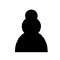
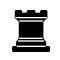
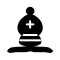
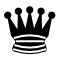
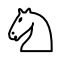
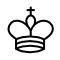
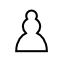
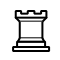
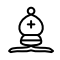
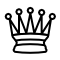
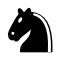
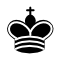

In [5]:
# this should run a game in the environment between two random bots
# NOTE: each game starts from a randomly selected opening
result = env.run(["random", "random"])
env.render(mode="ipython", width=1000, height=1000) 

 Chess bot
    - RAM: 5MB max
    - CPU: Single 2.20GHz core
    - Tamaño: <64KB comprimido
    - Tiempo: 0.1s simple delay
    - RAM total controlada: ~4.8MB
    - Valores y tablas compactas (~800KB total)
    - PST minimalistas pero efectivas

In [6]:
%%writefile main.py
#vesion 4.6(base)
import time,random
from Chessnut import Game

piece_sym = ['K', 'k', 'Q', 'q', 'R', 'r', 'B', 'b', 'N', 'n', 'P', 'p']
piece_val = [0, 0, 100, 100, 50, 50, 30, 30, 30, 30, 10, 10]
piece_val_dict = dict(zip(piece_sym, piece_val))

def evaluate_position(board):
    """Evaluación de posición usando get_piece en lugar de piece_at"""
    piece_values = {'P': 100, 'N': 320, 'B': 330, 'R': 500, 'Q': 900, 'K': 20000}
    piece_square_tables = {
        'P': [0,  0,  0,  0,  0,  0,  0,  0,
             50, 50, 50, 50, 50, 50, 50, 50,
             10, 10, 20, 30, 30, 20, 10, 10,
              5,  5, 10, 25, 25, 10,  5,  5,
              0,  0,  0, 20, 20,  0,  0,  0,
              5, -5,-10,  0,  0,-10, -5,  5,
              5, 10, 10,-20,-20, 10, 10,  5,
              0,  0,  0,  0,  0,  0,  0,  0],
        'N': [-50,-40,-30,-30,-30,-30,-40,-50,
              -40,-20,  0,  0,  0,  0,-20,-40,
              -30,  0, 10, 15, 15, 10,  0,-30,
              -30,  5, 15, 20, 20, 15,  5,-30,
              -30,  0, 15, 20, 20, 15,  0,-30,
              -30,  5, 10, 15, 15, 10,  5,-30,
              -40,-20,  0,  5,  5,  0,-20,-40,
              -50,-40,-30,-30,-30,-30,-40,-50]
    }
    
    score = 0
    for square in range(64):
        piece = board.get_piece(square)
        if piece != ' ':
            # Determinar color basado en si es mayúscula/minúscula
            is_white = piece.isupper()
            piece_symbol = piece.upper()
            
            # Valor base de la pieza
            value = piece_values.get(piece_symbol, 0)
            score += value if is_white else -value
            
            # Bonus posicional
            if piece_symbol in piece_square_tables:
                table = piece_square_tables[piece_symbol]
                position_value = table[square if is_white else 63-square]
                score += position_value if is_white else -position_value
    
    return score

def make_move(move, time_to_start_thinking, is_execute_print=True):
    duration = round(time.time() - time_to_start_thinking,3)
    if is_execute_print == True:
        print(f'[{move}, {duration}]')
    return move

def alpha_beta(game, depth, alpha, beta, maximizing, time_start):
    if time.time() - time_start > 0.08:  # Control de tiempo
        return None, evaluate_position(game.board)
    
    if depth == 0 or game.status >= Game.DRAW:
        return None, evaluate_position(game.board)

    best_move = None
    if maximizing:
        max_eval = float('-inf')
        for move in game.get_moves():
            g = Game(game.board)
            g.apply_move(move)
            _, eval_score = alpha_beta(g, depth-1, alpha, beta, False, time_start)
            if eval_score > max_eval:
                max_eval = eval_score
                best_move = move
            alpha = max(alpha, eval_score)
            if beta <= alpha:
                break
        return best_move, max_eval
    else:
        min_eval = float('inf')
        for move in game.get_moves():
            g = Game(game.board)
            g.apply_move(move)
            _, eval_score = alpha_beta(g, depth-1, alpha, beta, True, time_start)
            if eval_score < min_eval:
                min_eval = eval_score
                best_move = move
            beta = min(beta, eval_score)
            if beta <= alpha:
                break
        return best_move, min_eval

def chess_bot(obs):
    time_start = time.time()
    game = Game(obs.board)
    moves = list(game.get_moves())
    
    # Aperturas predefinidas (blancas)
    if obs.mark == 'white':
        if obs.step == 0 and 'e2e4' in moves: return make_move('e2e4', time_start)
        if obs.step == 2 and 'f1c4' in moves: return make_move('f1c4', time_start)
        if obs.step == 4 and 'g1f3' in moves: return make_move('g1f3', time_start)

    # Verificar si el movimiento conduce a jaque mate
    for move in moves:
        g = Game(game.get_fen())
        g.apply_move(move)
        opponent_moves = list(g.get_moves())
        if not opponent_moves:
            # Asumimos jaque mate si el oponente no tiene movimientos
            return make_move(move, time_start)

    # Búsqueda alfa-beta con profundidad variable
    depth = 3 if obs.step < 20 else 2  # Reducir profundidad en el medio juego
    best_move, _ = alpha_beta(game, depth, float('-inf'), float('inf'), True, time_start)
    
    if best_move:
        return make_move(best_move, time_start)
    
    # Fallback a movimiento de captura o aleatorio
    for move in moves:
        if game.board.get_piece(Game.xy2i(move[2:4])) != ' ':
            return make_move(move, time_start)
    
    return make_move(random.choice(moves), time_start)

Writing main.py


[e2e4, 0.005]
[f1c4, 0.007]
[g1f3, 0.008]
[c4f7, 0.276]
[f3g5, 0.217]
[g5h7, 0.248]
[h7f8, 0.166]
[f8d7, 0.224]
[d7e5, 0.264]
[d1h5, 0.359]
[h5e8, 0.483]
[e5f7, 0.143]
Agent exit status/reward/time left: 
	 DONE / 1 / 8.517936
	 DONE / 0 / 10





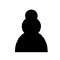
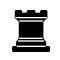
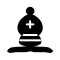
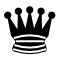
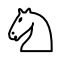
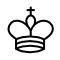
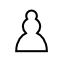
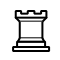
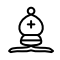
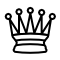
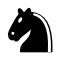
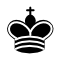

In [7]:
result = env.run(["main.py", "random"])
print("Agent exit status/reward/time left: ")
# look at the generated replay.json and print out the agent info
for agent in result[-1]:
    print("\t", agent.status, "/", agent.reward, "/", agent.observation.remainingOverageTime)
print("\n")
# render the game
env.render(mode="ipython", width=1000, height=1000) 